In [25]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch_geometric

!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.1.0+cu118.html

Found existing installation: torch-scatter 2.1.2+pt21cu118
Uninstalling torch-scatter-2.1.2+pt21cu118:
  Successfully uninstalled torch-scatter-2.1.2+pt21cu118
Found existing installation: torch-sparse 0.6.18+pt21cu118
Uninstalling torch-sparse-0.6.18+pt21cu118:
  Successfully uninstalled torch-sparse-0.6.18+pt21cu118
Found existing installation: torch_geometric 2.4.0
Uninstalling torch_geometric-2.4.0:
  Successfully uninstalled torch_geometric-2.4.0
Found existing installation: torch-cluster 1.6.3+pt21cu118
Uninstalling torch-cluster-1.6.3+pt21cu118:
  Successfully uninstalled torch-cluster-1.6.3+pt21cu118
  Using cached torch_geometric-2.4.0-py3-none-any.whl (1.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-geometric-temporal 0.54.0 requires torch-scatter, which is not installed.
torch-geometric-temporal 0.54.0 requires torch-sparse, which is no

In [26]:
print(torch.version.cuda)

11.8


In [27]:
!pip install torch-geometric-temporal

In [156]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import DCRNN
from torch_geometric_temporal.dataset import PedalMeDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

Here I used PedalMe London Bicycle Deliveries dataset https://github.com/benedekrozemberczki/spatiotemporal_datasets/

In [117]:
loader = PedalMeDatasetLoader()
dataset = loader.get_dataset()
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

In [139]:
# Recurrent GNN model class
class RGNN(torch.nn.Module):
  def __init__(self, node_features, hidden_dim, num_hidden_layers=1, filter_size=1):
    super(RGNN, self).__init__()
    self.node_features = node_features
    self.num_hidden_layers = num_hidden_layers
    self.filter_size = filter_size
    self.input_layer = DCRNN(node_features, hidden_dim, filter_size)
    self.hidden_layer = DCRNN(hidden_dim, hidden_dim, filter_size)
    self.linear = torch.nn.Linear(hidden_dim, 1)

  def forward(self, x, edge_index, edge_weight):
    h = self.input_layer(x, edge_index, edge_weight)
    h = F.relu(h)
    for i in range(self.num_hidden_layers):
      h = self.hidden_layer(h, edge_index, edge_weight)
      h = F.relu(h)
    h = self.linear(h)
    return h

In [143]:
model = RGNN(4, 16, 3, 2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Train

In [144]:
model.train()

for epoch in tqdm(range(200)):
    cost = 0
    for time, snapshot in enumerate(train_dataset):
        y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = cost + torch.mean((y_hat-snapshot.y)**2)
    cost = cost / (time+1)
    cost.backward()
    optimizer.step()
    optimizer.zero_grad()

100%|██████████| 200/200 [00:19<00:00, 10.32it/s]


#Evaluate model

In [146]:
model.eval()
cost = 0
predictions = []
ground_truth = []
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    predictions.append(y_hat)
    ground_truth.append(snapshot.y)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.4898


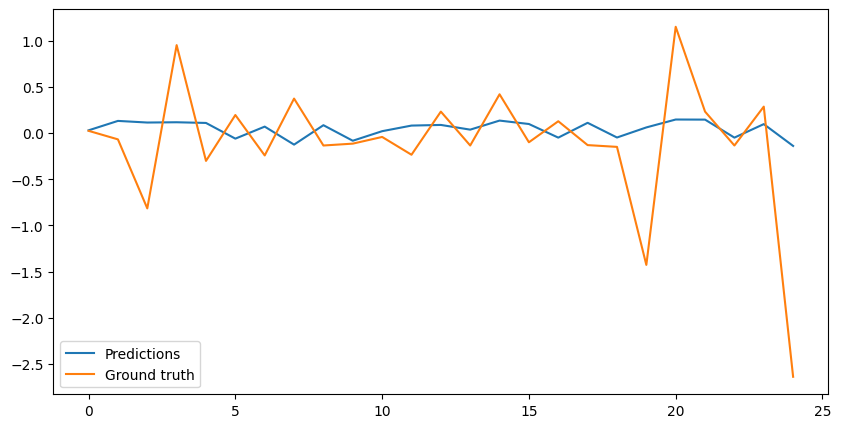

In [155]:
location = 9
preds = np.asarray([pred[location].detach().cpu().numpy() for pred in predictions])
truth = np.asarray([tr[location].cpu().numpy() for tr in ground_truth])
plt.figure(figsize=(10,5))
plt.plot(preds, label="Predictions")
plt.plot(truth, label="Ground truth")
plt.legend()